In [57]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [58]:
(train_images,_), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

(60000, 28, 28)

In [59]:
train_images.shape

(60000, 28, 28)

In [60]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

In [61]:
train_images = (train_images - 127.5) / 127.5
train_images[56782, :10, :10]                    #normalization between -1 and 1

array([[[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.41960785]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.99215686],
        [-1.        ],
        [-1.        ],
        [-1.        ],
        [-0.39607844],
        [ 0.62352943]],

       [[-1.        ],
        [-1.        ],
        [-1.        ],
   

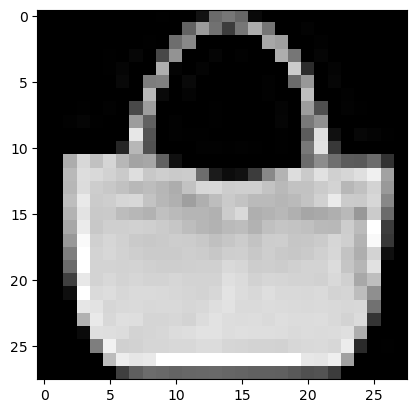

In [62]:
plt.imshow(train_images[100].squeeze(), cmap = 'gray')

In [63]:
buffer_size = 60000
batch_size = 128

In [64]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [65]:
def generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 100))
    model.add(layers.ReLU())

    model.add(layers.Dense(128))
    model.add(layers.ReLU())

    model.add(layers.Dense(256))
    model.add(layers.ReLU())

    model.add(layers.Dense(784, activation = 'tanh'))
    model.add(layers.Reshape((28,28,1)))

    return model

In [66]:
generator = generator_model()

generator.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 784)            │       201,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,296 (973.81 KB)

 Trainable params: 249,296 (973.81 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)

generated_image.shape

TensorShape([1, 28, 28, 1])

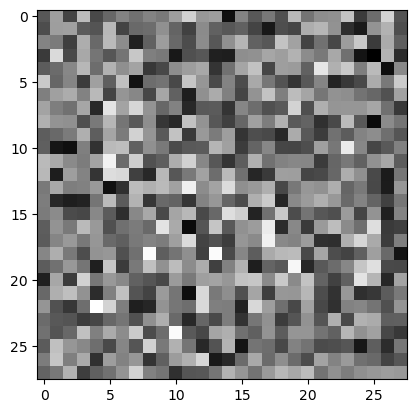

In [68]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [69]:
def discriminator_model():

    model = tf.keras.Sequential()
    model.add(layers.Input(shape = (28, 28, 1)))
    model.add(layers.Flatten())

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(0.3))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model


In [70]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,177 (946.00 KB)

 Trainable params: 242,177 (946.00 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
discriminator = discriminator_model()
output = discriminator(generated_image)
print(output)

tf.Tensor([[0.49118772]], shape=(1, 1), dtype=float32)


In [72]:
bce = tf.keras.losses.BinaryCrossentropy()

In [73]:
def discriminator_loss(real_output, fake_output):

    real_loss = bce(tf.ones_like(real_output), real_output)

    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss

    return total_loss


In [74]:
def generator_loss(fake_output):

    gen_loss = bce(tf.ones_like(fake_output), fake_output)

    return gen_loss

In [75]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [76]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                               discriminator_optimizer = discriminator_optimizer,
                               generator = generator,
                               discriminator = discriminator)

In [77]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [78]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output)


In [79]:
def generate_and_plot_images(model, epoch, test_input):
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (8,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        pred = (predictions[i, :, :, 0] +1) * 127.5
        pred = np.array(pred)
        plt.imshow(pred.astype(np.uint8), cmap = 'gray')
        plt.axis('off')

    plt.savefig('images_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [80]:
def train(dataset, epochs):

    gen_loss_list = []
    disc_loss_list = []

    real_score_list = []
    fake_score_list = []
    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)

        print(f'Training started with epoch {epoch + 1} with {num_batches} batches...')

        total_gen_loss = 0
        total_disc_loss = 0

        for batch in dataset:
            gen_loss, disc_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
    
        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches
    
        print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score, %.2f%%, fake_score %.2f%%' %
             (epoch + 1, mean_gen_loss, mean_disc_loss, real_score * 100, fake_score * 100))
    
        generate_and_plot_images(generator, epoch + 1, seed)
    
        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)
    
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return gen_loss_list, disc_loss_list, real_score_list, fake_score_list


  0%|                                                    | 0/50 [00:00<?, ?it/s]

Training started with epoch 1 with 469 batches...


2024-06-26 04:37:33.300922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch     1: generator 1.949, discriminator 0.827, real_score, 72.68%, fake_score 23.25%


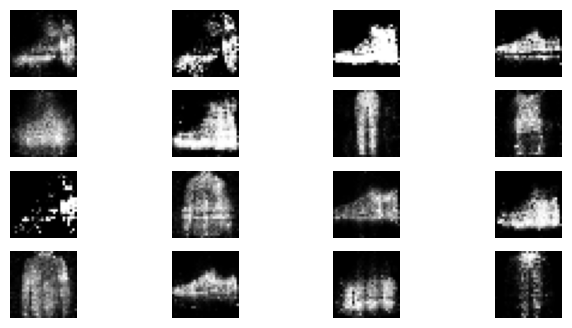

  2%|▉                                           | 1/50 [00:02<02:05,  2.56s/it]

Time for epoch 1 is 2.5644516944885254 sec
Training started with epoch 2 with 469 batches...


2024-06-26 04:37:35.829544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch     2: generator 1.928, discriminator 0.847, real_score, 68.93%, fake_score 20.74%


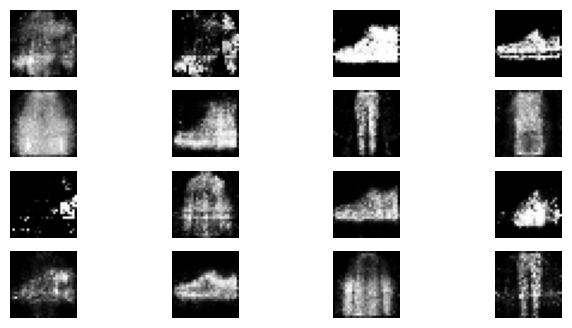

  4%|█▊                                          | 2/50 [00:05<02:01,  2.52s/it]

Time for epoch 2 is 2.491960287094116 sec
Training started with epoch 3 with 469 batches...


2024-06-26 04:37:38.294197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch     3: generator 2.079, discriminator 0.808, real_score, 70.67%, fake_score 22.75%


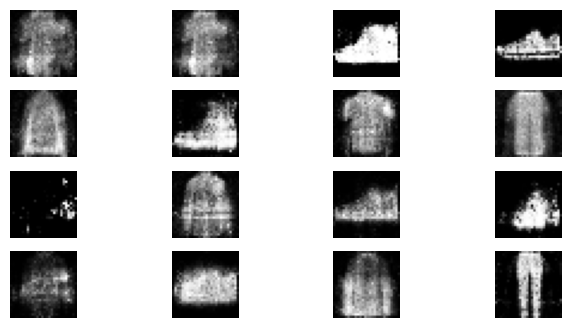

  6%|██▋                                         | 3/50 [00:07<02:03,  2.63s/it]

Time for epoch 3 is 2.7617127895355225 sec
Training started with epoch 4 with 469 batches...


2024-06-26 04:37:41.192968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch     4: generator 2.222, discriminator 0.798, real_score, 69.41%, fake_score 28.89%


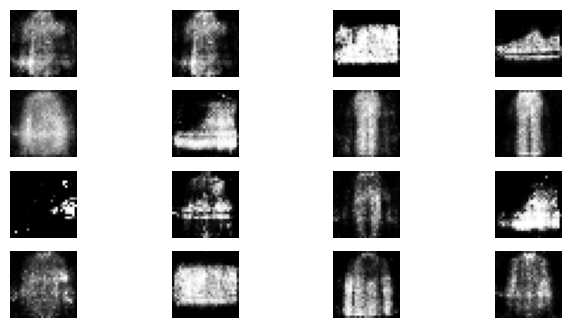

  8%|███▌                                        | 4/50 [00:10<02:00,  2.63s/it]

Time for epoch 4 is 2.625772476196289 sec
Training started with epoch 5 with 469 batches...


2024-06-26 04:37:43.686094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch     5: generator 1.984, discriminator 0.806, real_score, 77.84%, fake_score 21.58%


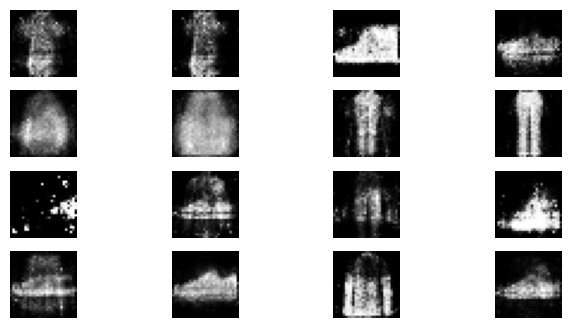

 10%|████▍                                       | 5/50 [00:12<01:55,  2.58s/it]

Time for epoch 5 is 2.4836156368255615 sec
Training started with epoch 6 with 469 batches...


2024-06-26 04:37:46.161342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch     6: generator 1.860, discriminator 0.879, real_score, 73.73%, fake_score 16.80%


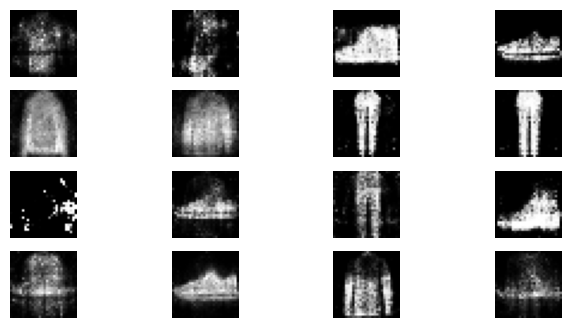

 12%|█████▎                                      | 6/50 [00:15<01:51,  2.54s/it]

Time for epoch 6 is 2.473909616470337 sec
Training started with epoch 7 with 469 batches...


2024-06-26 04:37:48.762577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch     7: generator 2.131, discriminator 0.796, real_score, 69.42%, fake_score 17.14%


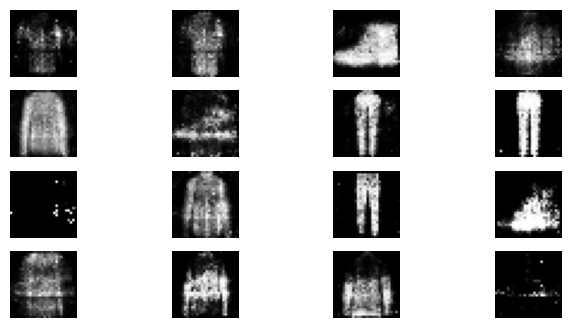

 14%|██████▏                                     | 7/50 [00:18<01:50,  2.56s/it]

Time for epoch 7 is 2.5935702323913574 sec
Training started with epoch 8 with 469 batches...


2024-06-26 04:37:51.248769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch     8: generator 1.894, discriminator 0.852, real_score, 64.60%, fake_score 41.16%


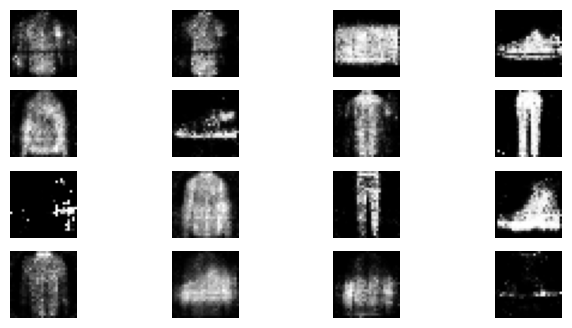

 16%|███████                                     | 8/50 [00:20<01:46,  2.53s/it]

Time for epoch 8 is 2.469653844833374 sec
Training started with epoch 9 with 469 batches...


2024-06-26 04:37:53.724713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch     9: generator 1.766, discriminator 0.883, real_score, 69.59%, fake_score 30.81%


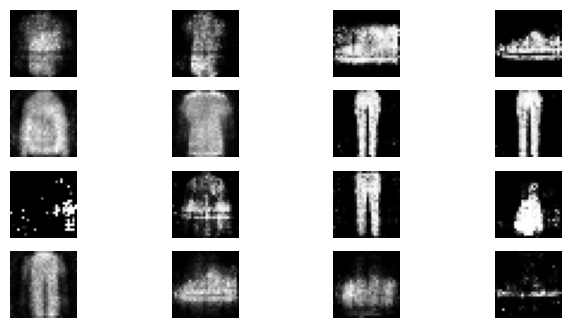

 18%|███████▉                                    | 9/50 [00:23<01:47,  2.62s/it]

Time for epoch 9 is 2.8209056854248047 sec
Training started with epoch 10 with 469 batches...


2024-06-26 04:37:56.594662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    10: generator 2.291, discriminator 0.814, real_score, 76.35%, fake_score 21.44%


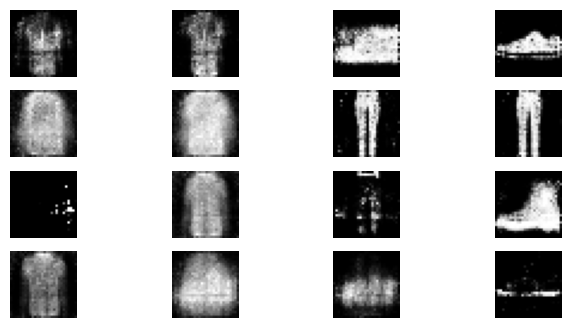

 20%|████████▌                                  | 10/50 [00:26<01:46,  2.66s/it]

Time for epoch 10 is 2.7365188598632812 sec
Training started with epoch 11 with 469 batches...


2024-06-26 04:37:59.399763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    11: generator 1.931, discriminator 0.836, real_score, 83.21%, fake_score 19.23%


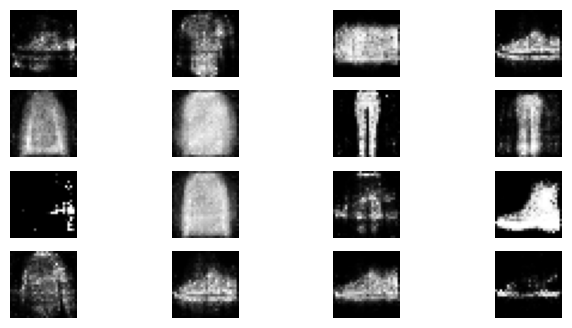

 22%|█████████▍                                 | 11/50 [00:28<01:42,  2.64s/it]

Time for epoch 11 is 2.5919911861419678 sec
Training started with epoch 12 with 469 batches...


2024-06-26 04:38:01.986076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    12: generator 1.958, discriminator 0.881, real_score, 69.52%, fake_score 26.26%


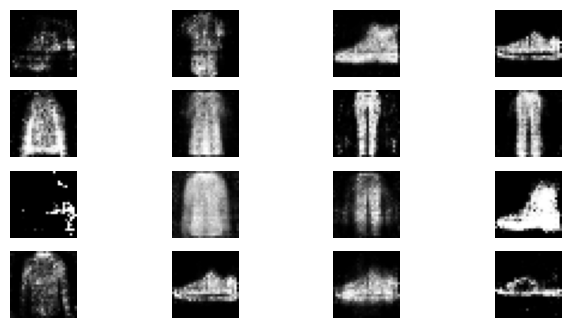

 24%|██████████▎                                | 12/50 [00:31<01:39,  2.63s/it]

Time for epoch 12 is 2.5978684425354004 sec
Training started with epoch 13 with 469 batches...


2024-06-26 04:38:04.533249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    13: generator 1.925, discriminator 0.836, real_score, 65.59%, fake_score 25.43%


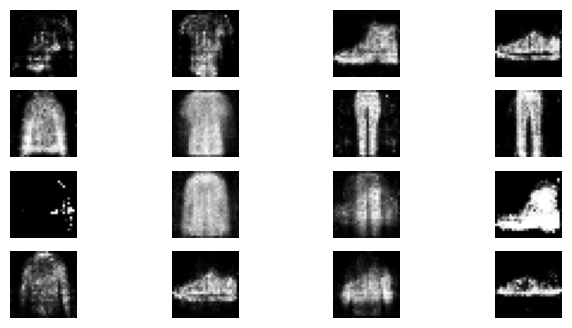

 26%|███████████▏                               | 13/50 [00:33<01:36,  2.60s/it]

Time for epoch 13 is 2.547414779663086 sec
Training started with epoch 14 with 469 batches...


2024-06-26 04:38:07.046917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    14: generator 2.111, discriminator 0.831, real_score, 69.87%, fake_score 30.41%


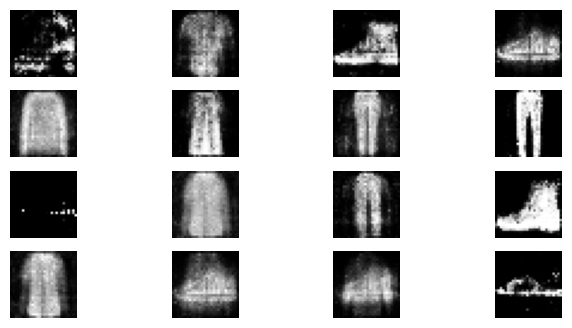

 28%|████████████                               | 14/50 [00:36<01:32,  2.57s/it]

Time for epoch 14 is 2.4967353343963623 sec
Training started with epoch 15 with 469 batches...


2024-06-26 04:38:09.573652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    15: generator 1.988, discriminator 0.820, real_score, 70.45%, fake_score 20.28%


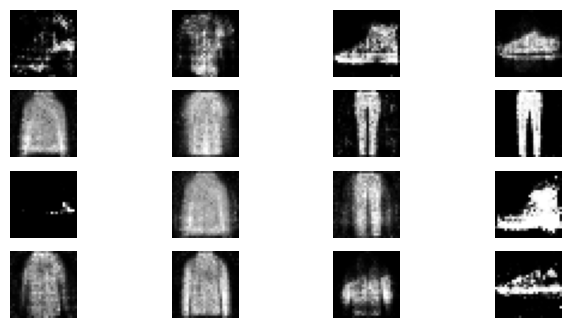

 30%|████████████▉                              | 15/50 [00:38<01:29,  2.56s/it]

Time for epoch 15 is 2.5261008739471436 sec
Training started with epoch 16 with 469 batches...


2024-06-26 04:38:12.045891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    16: generator 1.949, discriminator 0.834, real_score, 75.63%, fake_score 24.42%


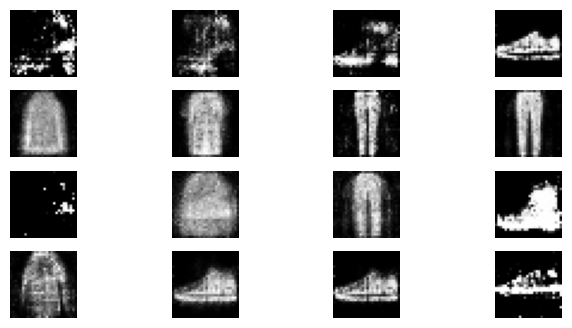

 32%|█████████████▊                             | 16/50 [00:41<01:29,  2.64s/it]

Time for epoch 16 is 2.8288516998291016 sec
Training started with epoch 17 with 469 batches...


2024-06-26 04:38:14.916344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    17: generator 1.974, discriminator 0.838, real_score, 79.72%, fake_score 26.41%


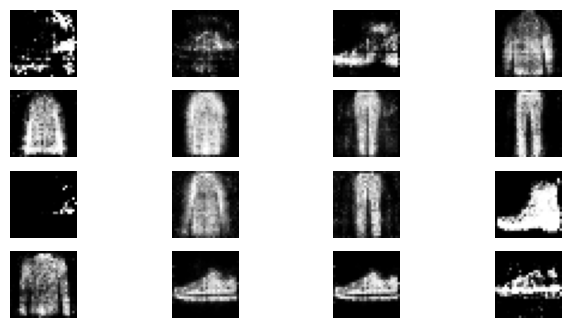

 34%|██████████████▌                            | 17/50 [00:44<01:26,  2.61s/it]

Time for epoch 17 is 2.5292346477508545 sec
Training started with epoch 18 with 469 batches...


2024-06-26 04:38:17.429752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    18: generator 2.018, discriminator 0.834, real_score, 82.92%, fake_score 25.69%


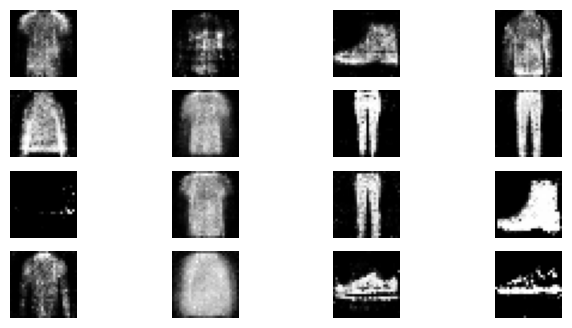

 36%|███████████████▍                           | 18/50 [00:46<01:22,  2.58s/it]

Time for epoch 18 is 2.507564067840576 sec
Training started with epoch 19 with 469 batches...


2024-06-26 04:38:19.964638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    19: generator 1.804, discriminator 0.889, real_score, 61.51%, fake_score 38.09%


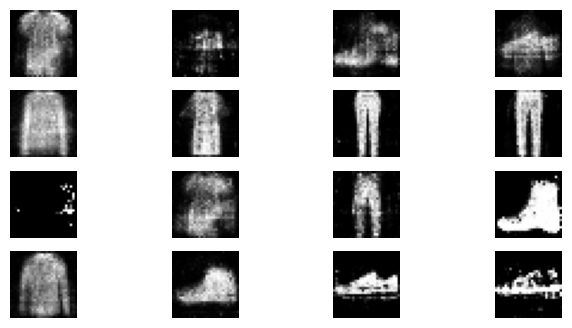

 38%|████████████████▎                          | 19/50 [00:49<01:19,  2.56s/it]

Time for epoch 19 is 2.522686243057251 sec
Training started with epoch 20 with 469 batches...


2024-06-26 04:38:22.475132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    20: generator 1.982, discriminator 0.874, real_score, 62.31%, fake_score 35.12%


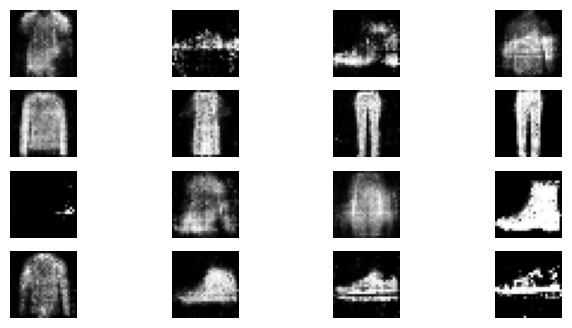

 40%|█████████████████▏                         | 20/50 [00:51<01:18,  2.62s/it]

Time for epoch 20 is 2.741945743560791 sec
Training started with epoch 21 with 469 batches...


2024-06-26 04:38:25.233296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    21: generator 1.827, discriminator 0.890, real_score, 72.84%, fake_score 25.28%


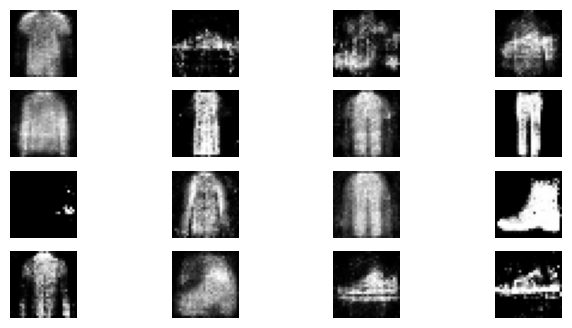

 42%|██████████████████                         | 21/50 [00:54<01:15,  2.59s/it]

Time for epoch 21 is 2.5240156650543213 sec
Training started with epoch 22 with 469 batches...


2024-06-26 04:38:27.777765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    22: generator 1.859, discriminator 0.874, real_score, 69.28%, fake_score 23.76%


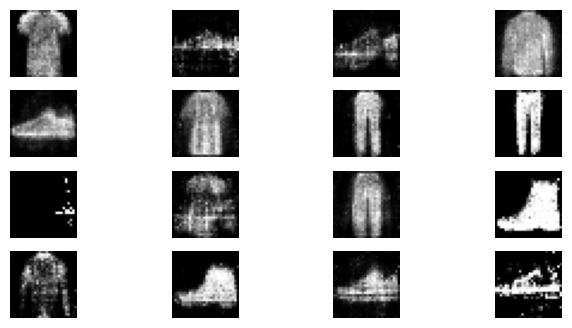

 44%|██████████████████▉                        | 22/50 [00:57<01:14,  2.68s/it]

Time for epoch 22 is 2.8852505683898926 sec
Training started with epoch 23 with 469 batches...


2024-06-26 04:38:30.620711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    23: generator 1.822, discriminator 0.921, real_score, 70.84%, fake_score 26.71%


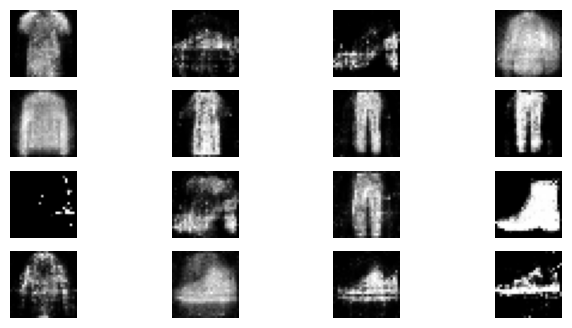

 46%|███████████████████▊                       | 23/50 [00:59<01:11,  2.63s/it]

Time for epoch 23 is 2.5194714069366455 sec
Training started with epoch 24 with 469 batches...


2024-06-26 04:38:33.115054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    24: generator 1.946, discriminator 0.867, real_score, 75.36%, fake_score 25.44%


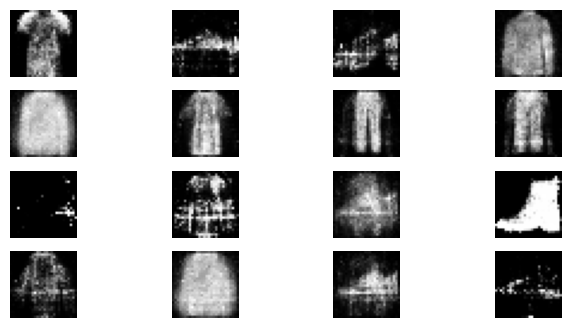

 48%|████████████████████▋                      | 24/50 [01:02<01:07,  2.59s/it]

Time for epoch 24 is 2.505007266998291 sec
Training started with epoch 25 with 469 batches...


2024-06-26 04:38:35.620294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    25: generator 1.970, discriminator 0.870, real_score, 69.79%, fake_score 19.55%


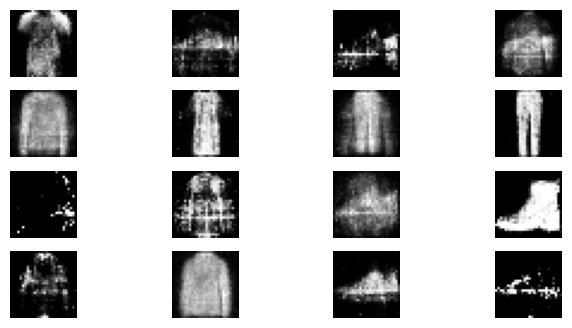

 50%|█████████████████████▌                     | 25/50 [01:04<01:04,  2.56s/it]

Time for epoch 25 is 2.4952497482299805 sec
Training started with epoch 26 with 469 batches...


2024-06-26 04:38:38.154980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    26: generator 1.922, discriminator 0.892, real_score, 71.91%, fake_score 40.10%


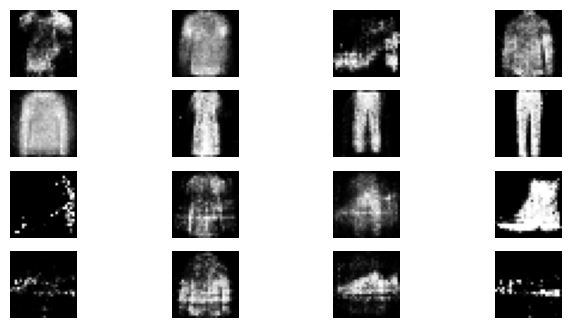

 52%|██████████████████████▎                    | 26/50 [01:07<01:01,  2.56s/it]

Time for epoch 26 is 2.542447805404663 sec
Training started with epoch 27 with 469 batches...


2024-06-26 04:38:40.692152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    27: generator 1.770, discriminator 0.924, real_score, 65.19%, fake_score 35.07%


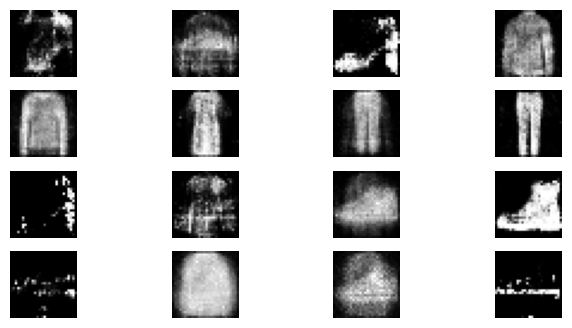

 54%|███████████████████████▏                   | 27/50 [01:09<00:58,  2.54s/it]

Time for epoch 27 is 2.505120038986206 sec
Training started with epoch 28 with 469 batches...


2024-06-26 04:38:43.190817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    28: generator 1.841, discriminator 0.905, real_score, 76.75%, fake_score 31.85%


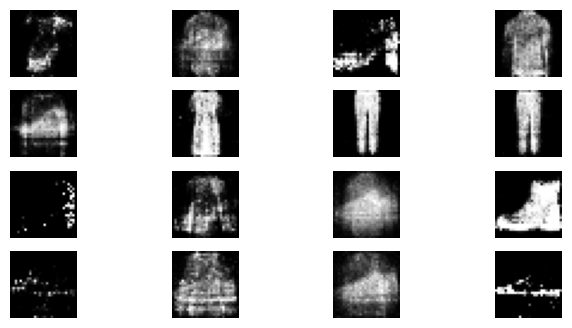

 56%|████████████████████████                   | 28/50 [01:12<00:55,  2.54s/it]

Time for epoch 28 is 2.5286214351654053 sec
Training started with epoch 29 with 469 batches...


2024-06-26 04:38:45.724088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    29: generator 1.882, discriminator 0.869, real_score, 73.98%, fake_score 22.03%


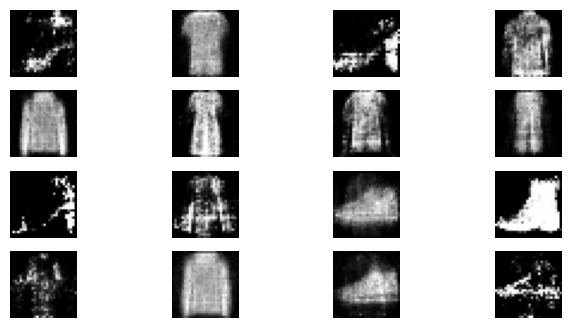

 58%|████████████████████████▉                  | 29/50 [01:15<00:55,  2.64s/it]

Time for epoch 29 is 2.882537841796875 sec
Training started with epoch 30 with 469 batches...


2024-06-26 04:38:48.591084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    30: generator 1.631, discriminator 0.975, real_score, 69.98%, fake_score 33.65%


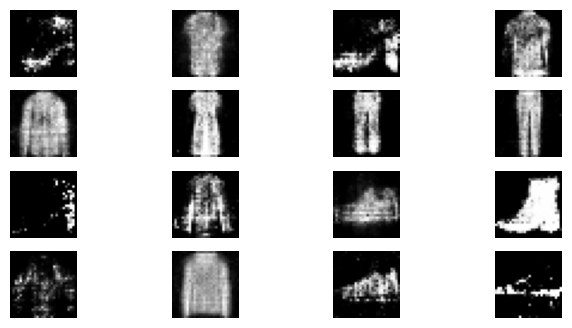

 60%|█████████████████████████▊                 | 30/50 [01:18<00:53,  2.66s/it]

Time for epoch 30 is 2.693264961242676 sec
Training started with epoch 31 with 469 batches...


2024-06-26 04:38:51.353399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    31: generator 1.778, discriminator 0.935, real_score, 88.78%, fake_score 17.34%


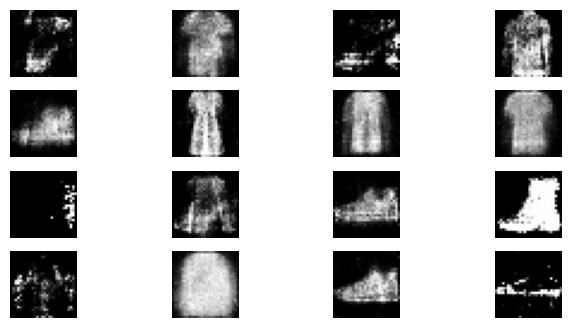

 62%|██████████████████████████▋                | 31/50 [01:20<00:49,  2.63s/it]

Time for epoch 31 is 2.5539801120758057 sec
Training started with epoch 32 with 469 batches...


2024-06-26 04:38:53.863773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    32: generator 1.799, discriminator 0.907, real_score, 73.19%, fake_score 28.63%


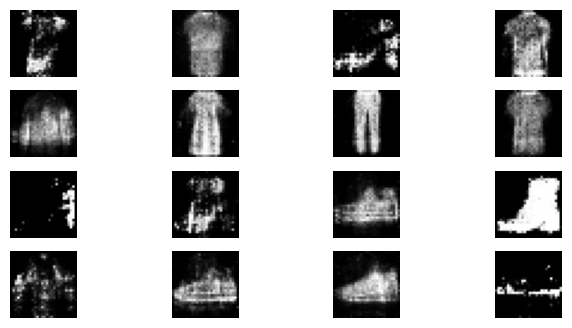

 64%|███████████████████████████▌               | 32/50 [01:23<00:46,  2.59s/it]

Time for epoch 32 is 2.509456157684326 sec
Training started with epoch 33 with 469 batches...


2024-06-26 04:38:56.372545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    33: generator 1.731, discriminator 0.939, real_score, 75.08%, fake_score 21.50%


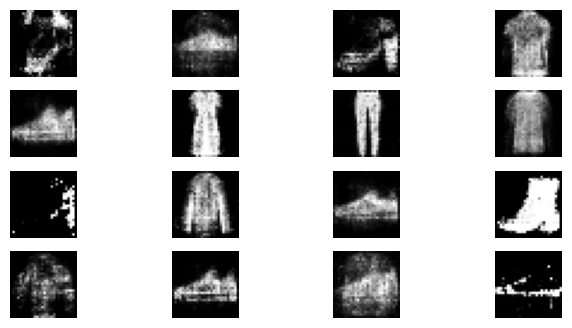

 66%|████████████████████████████▍              | 33/50 [01:25<00:43,  2.57s/it]

Time for epoch 33 is 2.5125176906585693 sec
Training started with epoch 34 with 469 batches...


2024-06-26 04:38:58.823609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    34: generator 2.145, discriminator 0.858, real_score, 64.26%, fake_score 28.61%


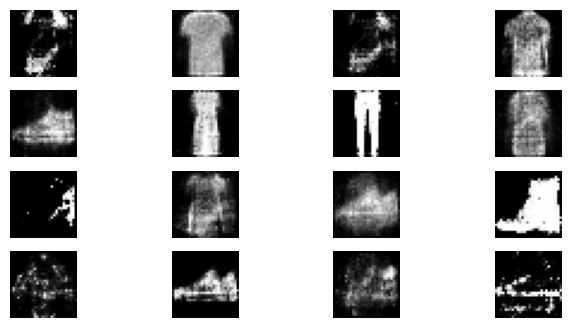

 68%|█████████████████████████████▏             | 34/50 [01:28<00:40,  2.53s/it]

Time for epoch 34 is 2.4470293521881104 sec
Training started with epoch 35 with 469 batches...


2024-06-26 04:39:01.344705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    35: generator 1.849, discriminator 0.897, real_score, 66.29%, fake_score 33.22%


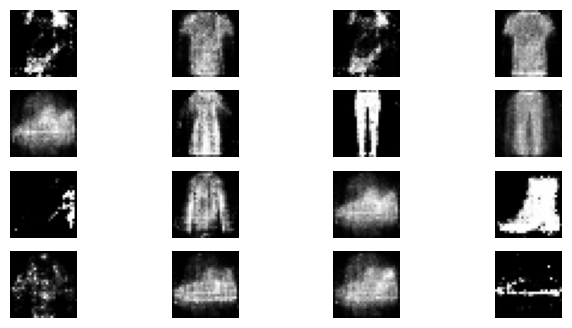

 70%|██████████████████████████████             | 35/50 [01:30<00:39,  2.64s/it]

Time for epoch 35 is 2.9020063877105713 sec
Training started with epoch 36 with 469 batches...


2024-06-26 04:39:04.245891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    36: generator 1.894, discriminator 0.912, real_score, 76.21%, fake_score 24.88%


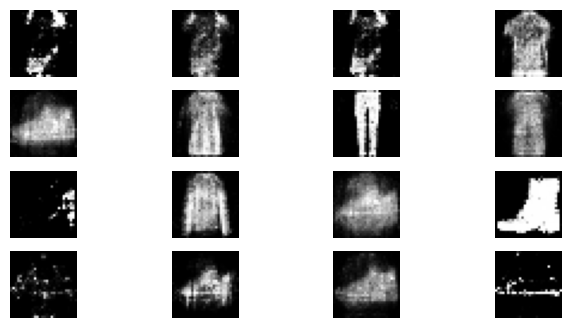

 72%|██████████████████████████████▉            | 36/50 [01:33<00:36,  2.61s/it]

Time for epoch 36 is 2.5423882007598877 sec
Training started with epoch 37 with 469 batches...


2024-06-26 04:39:06.867346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    37: generator 2.101, discriminator 0.871, real_score, 68.91%, fake_score 27.40%


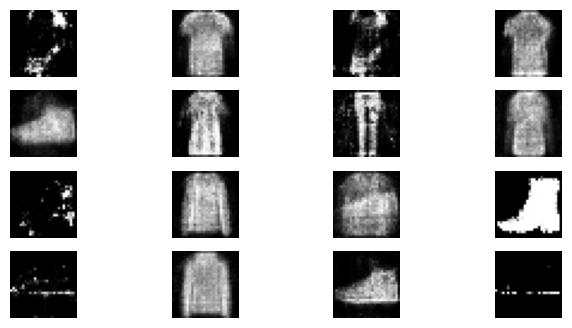

 74%|███████████████████████████████▊           | 37/50 [01:36<00:33,  2.61s/it]

Time for epoch 37 is 2.600431203842163 sec
Training started with epoch 38 with 469 batches...


2024-06-26 04:39:09.413014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    38: generator 1.791, discriminator 0.892, real_score, 79.80%, fake_score 28.64%


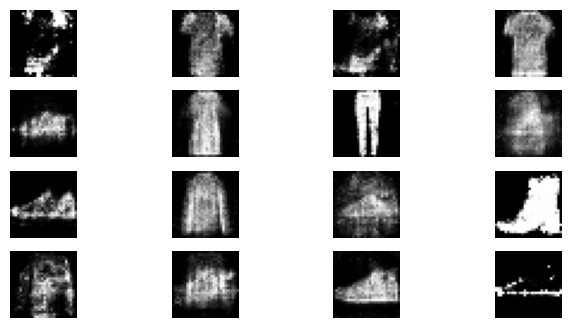

 76%|████████████████████████████████▋          | 38/50 [01:38<00:31,  2.59s/it]

Time for epoch 38 is 2.5550038814544678 sec
Training started with epoch 39 with 469 batches...


2024-06-26 04:39:11.973795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    39: generator 1.902, discriminator 0.903, real_score, 71.90%, fake_score 22.21%


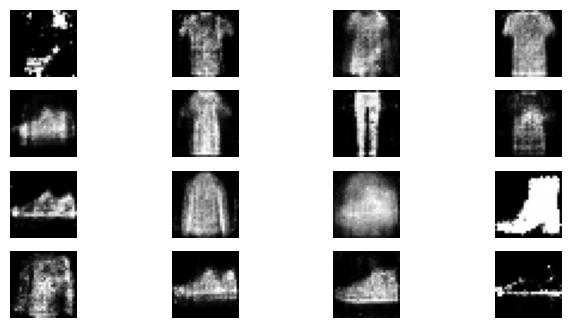

 78%|█████████████████████████████████▌         | 39/50 [01:41<00:28,  2.58s/it]

Time for epoch 39 is 2.5482707023620605 sec
Training started with epoch 40 with 469 batches...


2024-06-26 04:39:14.479502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    40: generator 1.661, discriminator 0.934, real_score, 78.65%, fake_score 20.70%


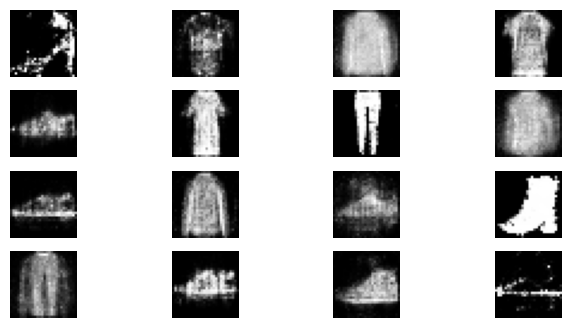

 80%|██████████████████████████████████▍        | 40/50 [01:43<00:26,  2.63s/it]

Time for epoch 40 is 2.7530198097229004 sec
Training started with epoch 41 with 469 batches...


2024-06-26 04:39:17.258923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    41: generator 1.814, discriminator 0.924, real_score, 72.98%, fake_score 29.47%


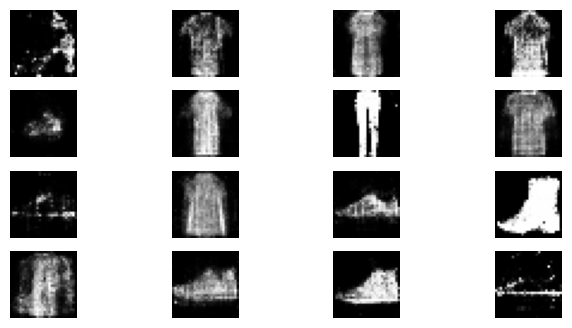

 82%|███████████████████████████████████▎       | 41/50 [01:46<00:24,  2.71s/it]

Time for epoch 41 is 2.87319016456604 sec
Training started with epoch 42 with 469 batches...


2024-06-26 04:39:20.152566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    42: generator 1.846, discriminator 0.886, real_score, 74.24%, fake_score 16.61%


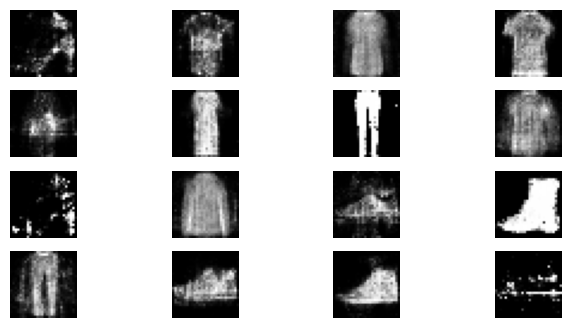

 84%|████████████████████████████████████       | 42/50 [01:49<00:21,  2.66s/it]

Time for epoch 42 is 2.5598933696746826 sec
Training started with epoch 43 with 469 batches...


2024-06-26 04:39:22.660897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    43: generator 1.961, discriminator 0.901, real_score, 69.37%, fake_score 26.43%


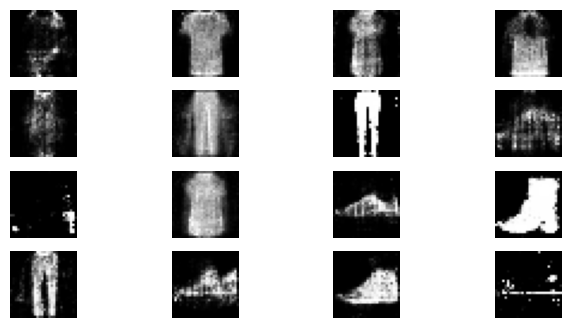

 86%|████████████████████████████████████▉      | 43/50 [01:51<00:18,  2.61s/it]

Time for epoch 43 is 2.4972305297851562 sec
Training started with epoch 44 with 469 batches...


2024-06-26 04:39:25.169730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    44: generator 1.751, discriminator 0.915, real_score, 64.39%, fake_score 30.63%


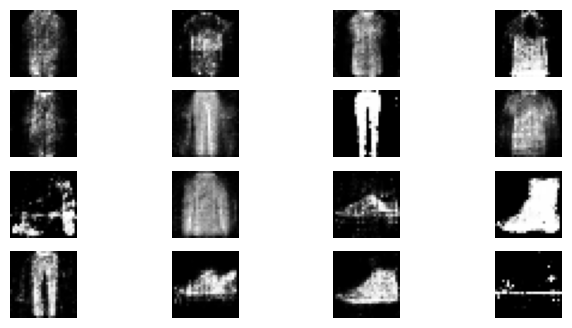

 88%|█████████████████████████████████████▊     | 44/50 [01:54<00:15,  2.58s/it]

Time for epoch 44 is 2.503321647644043 sec
Training started with epoch 45 with 469 batches...


2024-06-26 04:39:27.698104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    45: generator 1.822, discriminator 0.922, real_score, 70.82%, fake_score 31.20%


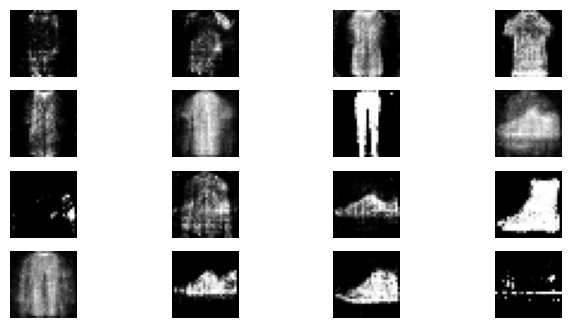

 90%|██████████████████████████████████████▋    | 45/50 [01:56<00:12,  2.57s/it]

Time for epoch 45 is 2.5583081245422363 sec
Training started with epoch 46 with 469 batches...


2024-06-26 04:39:30.278280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    46: generator 1.925, discriminator 0.898, real_score, 68.55%, fake_score 30.06%


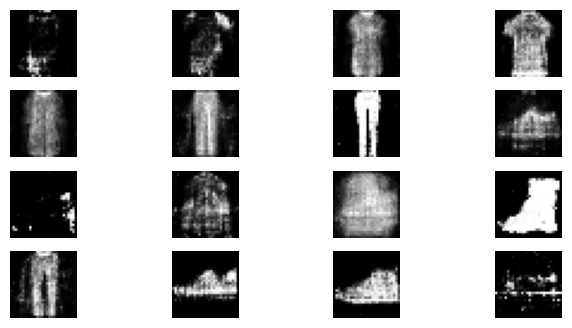

 92%|███████████████████████████████████████▌   | 46/50 [01:59<00:10,  2.57s/it]

Time for epoch 46 is 2.570826292037964 sec
Training started with epoch 47 with 469 batches...


2024-06-26 04:39:32.832468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    47: generator 1.609, discriminator 0.955, real_score, 77.48%, fake_score 30.52%


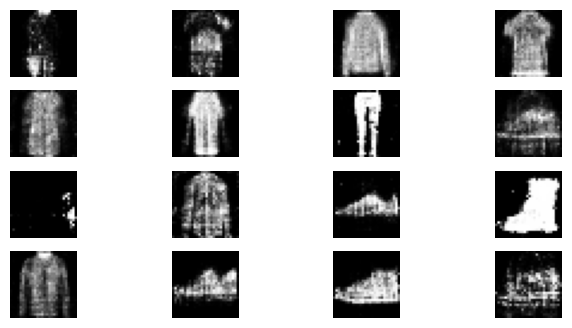

 94%|████████████████████████████████████████▍  | 47/50 [02:02<00:07,  2.56s/it]

Time for epoch 47 is 2.5390214920043945 sec
Training started with epoch 48 with 469 batches...


2024-06-26 04:39:35.349218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    48: generator 1.766, discriminator 0.936, real_score, 72.64%, fake_score 27.03%


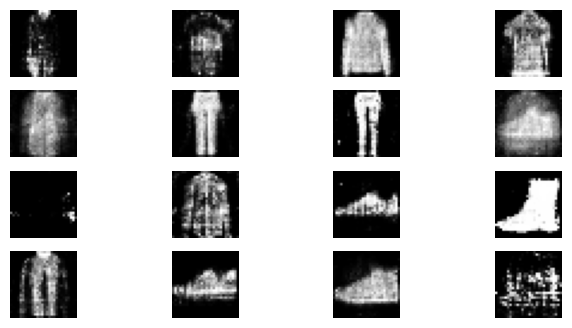

 96%|█████████████████████████████████████████▎ | 48/50 [02:04<00:05,  2.67s/it]

Time for epoch 48 is 2.9167537689208984 sec
Training started with epoch 49 with 469 batches...


2024-06-26 04:39:38.256308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    49: generator 1.744, discriminator 0.937, real_score, 68.38%, fake_score 30.61%


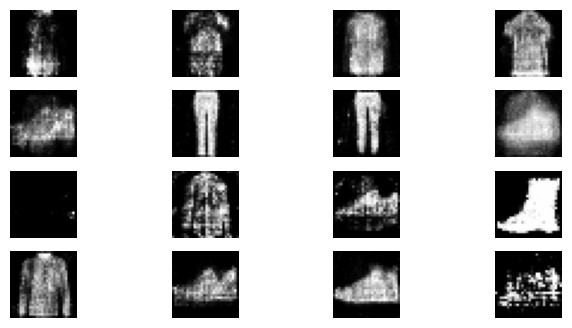

 98%|██████████████████████████████████████████▏| 49/50 [02:07<00:02,  2.62s/it]

Time for epoch 49 is 2.5047569274902344 sec
Training started with epoch 50 with 469 batches...


2024-06-26 04:39:40.794751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Losses after epoch    50: generator 2.004, discriminator 0.880, real_score, 63.64%, fake_score 20.73%


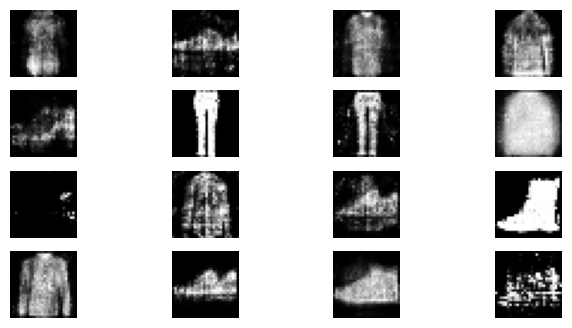

100%|███████████████████████████████████████████| 50/50 [02:10<00:00,  2.60s/it]

Time for epoch 50 is 2.7497670650482178 sec


In [83]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset, epochs = epochs)